In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


# 1 Data

## 1.1 Create Time Series Data

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [ ]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

## 1.2 Split Data

In [ ]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
print(len(x_train))
print(len(time_train))

print(len(x_valid))
print(len(time_valid))

1000
1000
461
461


In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
x_train[:5]

array([52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444],
      dtype=float32)

## 1.3 Windowed Dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


# 2 Model

In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

# 3 Forecast

In [ ]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.0114551 ],
       [-0.07286201],
       [ 0.11676861],
       [-0.10999094],
       [ 0.12328756],
       [-0.02670747],
       [-0.03262039],
       [-0.05878573],
       [ 0.13676128],
       [-0.07276282],
       [-0.00423317],
       [-0.05483079],
       [ 0.0784343 ],
       [-0.0807167 ],
       [ 0.08965117],
       [ 0.09202164],
       [ 0.024735  ],
       [ 0.10872339],
       [ 0.2669536 ],
       [ 0.467738  ]], dtype=float32), array([0.01711371], dtype=float32)]


forecast orig: 1441
forecast after slice: 461


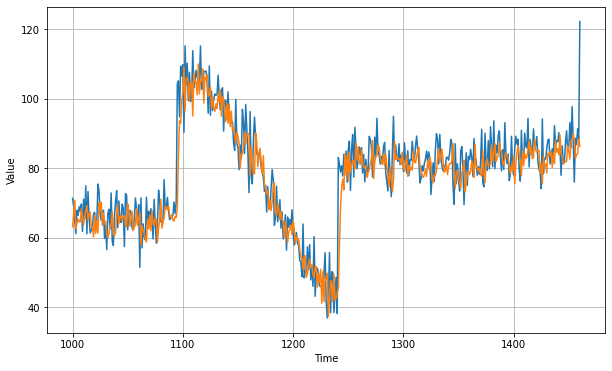

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:] 
# forecast[1000-20:] = forecast[980:]
# len(forecast) = 461
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# 4 Metric: MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1452127